In [2]:
import os
import requests
import zipfile
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, pyplot as plt

# INPUTS
# Choices of Country Border geojson Resolutions.
resolution_choices = ["01M", "03M", "10M", "30M", "60M"]

# resolution_choices[4] is 60M
res = resolution_choices[4]

# Choose country from ISO code
# country = "US"
country = "EL"

continent = "eu"  # na=North America, sa=South America, au=Australia, eu=Europe

print("Getting World's Country Borders")
world_country_borders = gpd.read_file(
    f"https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_{res}_2020_4326.geojson")
print(f"Filtering Country Border for: {country}")
country_border = world_country_borders[world_country_borders["CNTR_ID"] == country]



Getting World's Country Borders
Filtering Country Border for: EL


In [3]:
country_border

,id,CNTR_ID,CNTR_NAME,NAME_ENGL,NAME_FREN,ISO3_CODE,SVRG_UN,CAPT,EU_STAT,EFTA_STAT,CC_STAT,NAME_GERM,FID,geometry
70,EL,EL,Ελλάδα,Greece,Grèce,GRC,UN Member State,Athens,T,F,F,Griechenland,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35..."


In [4]:
country_name = country_border.NAME_ENGL.values[0]
country_name

'Greece'

In [5]:
# Clip US border to just CONUS - excludes Alaska, etc.
if country == "US":
    country_border = country_border.clip_by_rect(-140, 20, -50, 50)
    # clip_by_rect returns a geoseries, so turning back to a GDF
    country_border = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(country_border))
    country_border.plot()

In [9]:
len(country_border)

1

Getting Watershed Basin for Continent: eu
Intersecting Country Border with Continent Watershed Basin.


<Axes: >

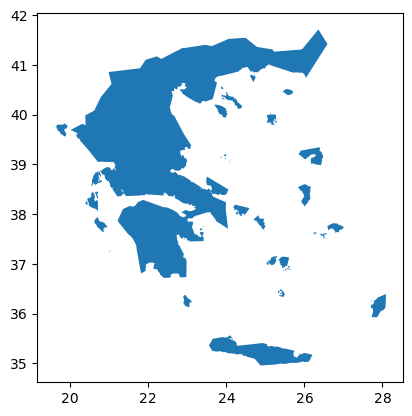

In [21]:
# Get Continent-wide Watershed Basin Boundaries
print(f"Getting Watershed Basin for Continent: {continent}")
url = f"https://data.hydrosheds.org/file/HydroBASINS/standard/hybas_{continent}_lev03_v1c.zip"
file_name = url.split("/")[-1]

r = requests.get(url)
with open(file_name, 'wb') as outfile:
    outfile.write(r.content)

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()

# Intersect Basin with only the wanted Country Boundary.
print("Intersecting Country Border with Continent Watershed Basin.")
continent_basin = gpd.read_file(file_name.split(".")[0]+".shp")
country_basin = gpd.overlay(
    country_border, continent_basin, how='intersection')

country_basin.plot()

In [20]:
# Get Rivers
print("Getting Continent Rivers.")
url = f"https://data.hydrosheds.org/file/HydroRIVERS/HydroRIVERS_v10_{continent}_shp.zip"
file_name = url.split("/")[-1]

r = requests.get(url)
with open(file_name, 'wb') as outfile:
    outfile.write(r.content)

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()

continent_rivers = gpd.read_file(os.path.join(
    f"HydroRIVERS_v10_{continent}_shp", f"HydroRIVERS_v10_{continent}.shp"))

# Clip rivers to country_basin extent. (This part takes a while.)
print("Intersecting Rivers with Country-wide watershed basin.")
country_river_basin = gpd.overlay(
    continent_rivers, country_basin, how='intersection')


Getting Continent Rivers.
Intersecting Rivers with Country-wide watershed basin.


,HYRIV_ID,NEXT_DOWN_1,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,...,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,20577637,20577638,20597827,4.05,181.8,10.0,17.64,17.6,0,0.087,...,0.0,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.35625 41.65000, 26.35625 41.643..."
1,20577638,20577639,20597827,2.42,179.3,224.2,8.51,5527.8,0,37.131,...,0.0,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.36875 41.61875, 26.39792 41.61875)"
2,20577639,20576829,20597827,8.55,171.0,232.5,47.80,5588.5,0,37.437,...,0.0,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.39792 41.61875, 26.40208 41.622..."
3,20577744,20577745,20597827,5.50,183.7,9.6,19.57,19.6,0,0.098,...,0.0,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.32500 41.65833, 26.33542 41.647..."
4,20577745,20577638,20597827,1.96,181.7,221.8,4.97,5501.7,0,37.000,...,0.0,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.34792 41.61458, 26.35208 41.618..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787,20708542,0,20708542,3.61,0.0,12.0,22.85,22.7,0,0.225,...,0.0,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.45208 35.02083, 25.45208 35.014..."
5788,20708543,0,20708543,2.29,0.0,10.1,16.17,16.0,0,0.148,...,0.0,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.52917 35.00833, 25.53542 35.002..."
5789,20708619,0,20708619,2.69,0.0,7.5,18.11,17.4,0,0.177,...,0.0,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.26667 35.00417, 25.28542 34.98542)"
5790,20708620,0,20708620,8.40,0.0,39.8,31.11,534.0,0,5.517,...,0.0,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.29375 35.03542, 25.30625 35.035..."


<Axes: >

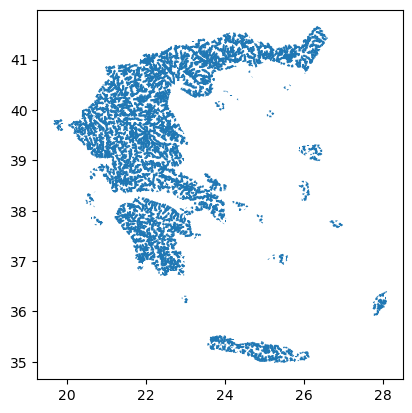

In [22]:
country_river_basin.plot()

In [23]:

# RIVER WIDTH config
country_river_basin['ORD_FLOW'].unique()

def assign_river_width(row):
    if row['ORD_FLOW'] == 1:
        return 0.8
    elif row['ORD_FLOW'] == 2:
        return 0.7
    elif row['ORD_FLOW'] == 3:
        return 0.6
    elif row['ORD_FLOW'] == 4:
        return 0.45
    elif row['ORD_FLOW'] == 5:
        return 0.35
    elif row['ORD_FLOW'] == 6:
        return 0.25
    elif row['ORD_FLOW'] == 7:
        return 0.2
    elif row['ORD_FLOW'] == 8:
        return 0.15
    elif row['ORD_FLOW'] == 9:
        return 0.1
    else:
        return 0

print("apply width values to rivers.")
country_river_basin['width'] = country_river_basin.apply(
    assign_river_width, axis=1)

country_river_basin['HYBAS_ID'].unique()

apply width values to rivers.


array([2030009230, 2030045150], dtype=int64)

In [24]:
country_river_basin

,HYRIV_ID,NEXT_DOWN_1,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,...,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,width
0,20577637,20577638,20597827,4.05,181.8,10.0,17.64,17.6,0,0.087,...,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.35625 41.65000, 26.35625 41.643...",0.15
1,20577638,20577639,20597827,2.42,179.3,224.2,8.51,5527.8,0,37.131,...,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.36875 41.61875, 26.39792 41.61875)",0.35
2,20577639,20576829,20597827,8.55,171.0,232.5,47.80,5588.5,0,37.437,...,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.39792 41.61875, 26.40208 41.622...",0.35
3,20577744,20577745,20597827,5.50,183.7,9.6,19.57,19.6,0,0.098,...,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.32500 41.65833, 26.33542 41.647...",0.15
4,20577745,20577638,20597827,1.96,181.7,221.8,4.97,5501.7,0,37.000,...,0.0,293802.3,293802.3,213,0,1,0,10,"LINESTRING (26.34792 41.61458, 26.35208 41.618...",0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787,20708542,0,20708542,3.61,0.0,12.0,22.85,22.7,0,0.225,...,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.45208 35.02083, 25.45208 35.014...",0.20
5788,20708543,0,20708543,2.29,0.0,10.1,16.17,16.0,0,0.148,...,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.52917 35.00833, 25.53542 35.002...",0.20
5789,20708619,0,20708619,2.69,0.0,7.5,18.11,17.4,0,0.177,...,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.26667 35.00417, 25.28542 34.98542)",0.20
5790,20708620,0,20708620,8.40,0.0,39.8,31.11,534.0,0,5.517,...,0.0,21105.3,21105.3,212,0,1,0,23,"LINESTRING (25.29375 35.03542, 25.30625 35.035...",0.25


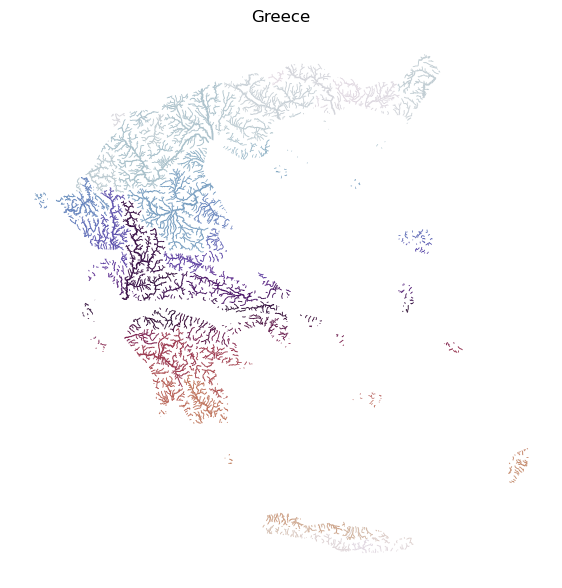

In [72]:
# PLOT
# print("Setup Plot")
fig, ax = plt.subplots(figsize=(7, 7.75))
plt.title(country_name)
country_river_basin.plot(ax=ax, column='MAIN_RIV', cmap=colormaps['twilight'],
                            linewidth=country_river_basin['width']*3,
                            #  edgecolor='black',
                            #  alpha=country_river_basin['width'],
                            categorical=True,
                            #  legend=True,
                            )
ax.set_axis_off()

In [73]:
print("Save Plot")
fig.savefig(f'{country}-river-basins.png', dpi=600,
            bbox_inches='tight', pad_inches=0, transparent=True)



Save Plot
